### Tensorflow example for MNIST
The goal of this demo is to correctly classify any handwritten digits on a sheet of paper.

Each feature in the MNIST dataset is a 784-dim vector, corresponding to the 28 x 28 flattened grayscale pixel image. The pixel intensities are 8-bit unsigned integers, falling into the range [0, 255].

This notebook reshapes a given image to meet the MNIST requirements.
 
Prerequisites on the raw image: 
  * The image must only contain digits
  * There must be white spaces beetween individual digits
  * The digits have been written on white papper

#### Hyper Parameter

In [1]:
%matplotlib inline

import input_data
import cv2
import numpy as np
import math
from scipy import ndimage
from array import array
from tensorflow.python.platform import gfile
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from PIL import Image

In [2]:
org_image_file  = "handwritten/paper_sheet_test_1.png"
copy_image_file = "final_result.jpeg"
green_rectangle_positions = "rectangle_shapes.json"
dictionary_processing_files = "pro-img/"
tmp_image_file= "/tmp/tmp_paper_sheet_test_image.png"
image_note_rectange_shape= "notes/rectangles_shape_01.jpg"
image_note_rectange_shift_1= "notes/rectangles_shift_01.jpg"
image_note_rectange_shift_2= "notes/rectangles_shift_02.png"
pixel_depth = 255.0  # color range:  0==black and 255==white.

#### Utility Fuctions

This function can change the width and height of a image plot, in case the default plot size is to small

In [3]:
figure_size= plt.rcParams["figure.figsize"]
print "original figure size: ", figure_size
def increasePlotSize(x,y):
    plt.rcParams["figure.figsize"] = {x,y}
def normalPlotSize():
    plt.rcParams["figure.figsize"] = figure_size 

original figure size:  [6.0, 4.0]


This function plots images vertical next to each other, in case its needed to save space

In [4]:
def plotParallelFigures(fileNameArray,cmap="gray"):
    parallel_figures = plt.figure()
    i=1
    # add pictures to subplot    
    for fileName in fileNameArray:
        parallel_figures.add_subplot(1,len(fileNameArray),i)
        #plt.rcParams["figure.figsize"] = {8,10}
        plt.axis('off')
        imgplot = plt.imshow((ndimage.imread(fileName)),cmap)
        i = i+1
    plt.show()

In [5]:
#Works as well, but plots the image in original size!
#def plotOriginalSize() :
    #from IPython.display import Image
    #from IPython.display import display
    #x = Image(filename=image_note_rectange_shape) 
    #y = Image(filename=image_note_rectange_shift) 
    #display(x, y)

In [6]:
def girdPlot(fileNameArray,cmap="gray") :
    # only 2 images per line
    number_of_figures = len(fileNameArray) -1 # must start counting by 0, because subplot2grid starts by index 0
    _w = 0 # keeps track of how many images are from left to right
    _h = 0 # adds a new row to the bottom if needed 
    
    if(number_of_figures < 2):
        parallel_figures_height=2
        parallel_figures_weight= number_of_figures +1
    else:
        parallel_figures_height= int(math.ceil((number_of_figures/2.0))) + 1
        parallel_figures_weight=2

    for fileName in fileNameArray:
        plt.subplot2grid((parallel_figures_height,parallel_figures_weight), (_h,_w), rowspan=1, colspan=1)
         #plt.rcParams["figure.figsize"] = {8,10}
        _w = _w + 1
        if (_w == parallel_figures_weight):
            _w = 0
            _h = _h + 1
        plt.axis('off')
        #plt.rcParams["figure.figsize"] = {18,20}
        imgplot = plt.imshow((ndimage.imread(fileName)),cmap)
    plt.show() 

This function saves the processed image in the tmp folder and plots the image

In [7]:
def plotSingleImage(image_data,cmap="gray"):
    cv2.imwrite(tmp_image_file, image_data)
    plt.imshow(image_data, cmap)
    plt.show()
    print "(width, height, channel):" , image_data.shape

## Plot the test image to be predicted

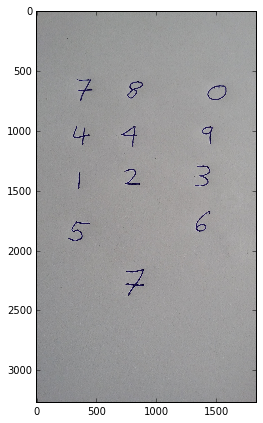

(width, height, channel): (3264, 1836, 3)


In [8]:
increasePlotSize(7.0,10.0)
image_data = (ndimage.imread(org_image_file))
plotSingleImage(image_data,cmap=None)

### There are several things we need to adjust on this image:
<br>
<dl>
    <dt> Color: the MNIST images for training are white digits on a black background </dt>
        <dd>- we currently have blue digets on a gray background </dd>
        <dd>- we currently have 3 color channels (RGB). The MNIST images use only the BINARY channel (black and white) </dd>
    <dt> Shape: the MNIST images for training have a shape of 28x28 </dt>
        <dd>- we currently have twelve digits in the image, each which individual shape </dd>
        <dd>- we currently have a shape of the total image of 3264x1836 </dd>
</dl>

## How to convert a RGB image into a BINARY (black and white) image :
<br>
<dl>
    <dt>Read the image as a grayscale image</dt>
        <dd>- this step is necessary </dd>
    <dt>Convert it to a binary image by adaptive thresholding or fixed-level thresholding</dt>
        <dd>-  all pixels with a "value > threashold" will become white, and everything else becomes black </dd>
        <dd>-  if you don't want to work out a threshold, you can use the Otsu's method. But this algorithm only works with 8bit images. </dd>
        <dd>-  cv.CV_THRESH_BINARY means every pixel greater than threshold becomes the maxValue (in your case 255), otherwise the value is 0. Obviously if your threshold is 0 everything becomes white (maxValue = 255) and if the value is 255 everything becomes black (i.e. 0).</dd>
</dl>

#### Read the image as a grayscale image

In [9]:
gray_image_data = cv2.imread(org_image_file, cv2.CV_LOAD_IMAGE_GRAYSCALE)

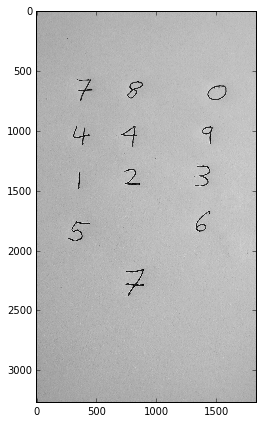

(width, height, channel): (3264, 1836)


In [10]:
plotSingleImage(gray_image_data,cmap="gray")

##### Convert it to a binary image by adaptive thresholding or fixed-level thresholding

In [11]:
(thresh, binary_image_data) = cv2.threshold(gray_image_data, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

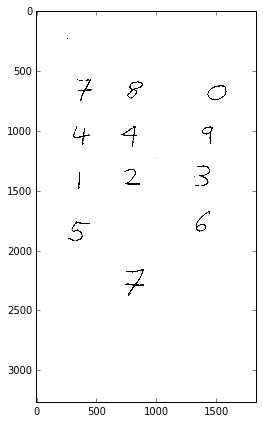

(width, height, channel): (3264, 1836)


In [12]:
plotSingleImage(binary_image_data,cmap="gray")

#####  Inverse the image color
Balck digits will become white and the background color will change to black, to match the MNIST training data

In [13]:
inverse_image_data = (pixel_depth-binary_image_data)

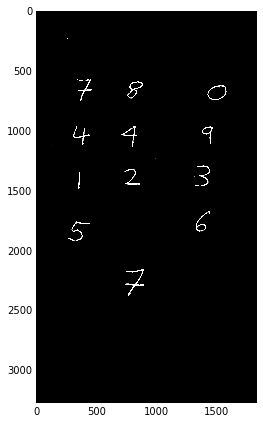

(width, height, channel): (3264, 1836)


In [14]:
plotSingleImage(inverse_image_data,cmap="gray")

### How to crop the image to extract the twelve digits :
<br>
<dl>
    <dt>Define rectangles of different shapes</dt>
        <dd>- Define the smallest and the largest width and height of a single digit (cropped_width and cropped_height) </dd>
        <dd>- Based on the two first loops we end up with 10x10 rectangles. (Width: (start 100, increase 20, until 280) ==>10)</dd>
    <dt>Move each rectangle across the full page </dt>
        <dd>- Move rectangle from top of page to button of page. Then repeat same search a litte more on page right  </dd>
        <dd>- "a little more on page right" is defined by variable shift_x and shift_y based on the last two loops</dd>
</dl>

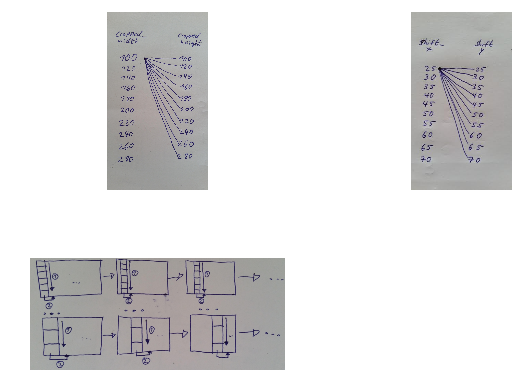

In [15]:
fileNames= [image_note_rectange_shape,image_note_rectange_shift_1,image_note_rectange_shift_2]
#plotParallelFigures(fileNames,cmap=None)
girdPlot(fileNames,cmap=None)

##### Crop for digits

A matrix with the size of the original image filled with '-1'.<br>
Used to save at which place a digit was allready found, so it isn't possible to recognize the same digit twice. <br>
That speeds up the process and stops the algorithm to create a mess of digits.

In [16]:
digit_image_found_marker = -np.ones(inverse_image_data.shape)

Create rectangles and use them to search for digits on the full paper <br>
To find the digits its needed to crop the paper in a lot of different ways. <br>
If there is only a single digit inside the cropped part we can find the smallest rectangle around that digit easily.

In [17]:
height, width = inverse_image_data.shape
print "full picture shape: ", width , ",", height

full picture shape:  1836 , 3264


 Find the smallest possible rectangle around a single digit inside the cropped image.
 ( Used afterwards to draw the green rectangle around the digit in the original image. )

In [18]:
def get_tailored_rectangle_position(top_left,bottom_right,gray_cropped):
    
    while np.sum(gray_cropped[0]) == 0:
        top_left[0] += 1
        gray_cropped = gray_cropped[1:]

    while np.sum(gray_cropped[:,0]) == 0:
        top_left[1] += 1
        gray_cropped = np.delete(gray_cropped,0,1)

    while np.sum(gray_cropped[-1]) == 0:
        bottom_right[0] -= 1
        gray_cropped = gray_cropped[:-1]

    while np.sum(gray_cropped[:,-1]) == 0:
         bottom_right[1] -= 1
         gray_cropped = np.delete(gray_cropped,-1,1)

    return gray_cropped, top_left ,bottom_right

Check if there is already a digit inside the current rectangle using the digit_image_found_marker array
  * in the initialized step everything is filled with -1 which obviously is nonzero
  * therefor we add +1 before we count the number of nonzero values
  * If this number is bigger than 20% of the actual image we would say that the space is used already and maybe we found exactly that digit already

In [19]:
def check_if_digit_was_already_found( bottom_right, top_left, digit_image_found_marker ):
    actual_w_h = bottom_right-top_left
    if (np.count_nonzero(digit_image_found_marker[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]+1) >
                                0.2*actual_w_h[0]*actual_w_h[1]):
        return True
    else:
        return False

Resizes the image to be quadratic

For example the row length is 140 and the cols are 80
  * Than the cols are padded with black pixels on the edges to reach 140 pixels
  * So the resulting image is 140 x 140 pixels

In [20]:
def resize_to_quadratic_image_shape(gray_cropped):
    rows,cols = gray_cropped.shape
    print "Before resizing to quadratic shape: " , gray_cropped.shape
    plotSingleImage(gray_cropped,cmap="gray")
    compl_dif = abs(rows-cols)
    half_Sm = compl_dif/2
    half_Big = half_Sm if half_Sm*2 == compl_dif else half_Sm+1
    if rows > cols:
        gray_cropped = np.lib.pad(gray_cropped,((0,0),(half_Sm,half_Big)),'constant')
    else:
        gray_cropped = np.lib.pad(gray_cropped,((half_Sm,half_Big),(0,0)),'constant')
    print "After resizing to quadratic shape: " , gray_cropped.shape
    plotSingleImage(gray_cropped,cmap="gray")
    return gray_cropped

Adapt image to meet MNIST requirements for shape:
 * resize image to 28x28 pixel box 
    * 20x20 inner bounding box
    * additional black lines at the image border to get a 28x28 image 

cv2.resize(IMAGE_DATA,(20,20)) will resize the image data to have 20 cols (width) and 20 rows (height)

In [21]:
def resize_to_MNIST_shape(gray_quadratic):          
    gray_MNIST_FORMAT = cv2.resize(gray_quadratic, (20, 20))
    gray_MNIST_FORMAT = np.lib.pad(gray_MNIST_FORMAT,((4,4),(4,4)),'constant')
    print "Resize to MNIST (28x28) shape: " , gray_MNIST_FORMAT.shape
    plotSingleImage(gray_MNIST_FORMAT,cmap="gray")
    return gray_MNIST_FORMAT

Shift digit inside the 28x28 pixel box using the center of mass. <br>
The digit will be centered in the 28x28 box.

In [22]:
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)
    #print cy,cx
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)
    return shiftx,shifty


def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

def center_digit_in_MNIST_frame(gray_MNIST_FORMAT):
    shiftx,shifty = getBestShift(gray_MNIST_FORMAT)
    shifted = shift(gray_MNIST_FORMAT,shiftx,shifty)
    gray_shifted = shifted 
    print "Shift digit to be in the center of 28x28 box: "
    plotSingleImage(gray_shifted,cmap="gray")
    return gray_shifted

Search for digits inside the entire image and save them as individual png files in MNIST format (28x28 pixels )

Before resizing to quadratic shape:  (12, 10)


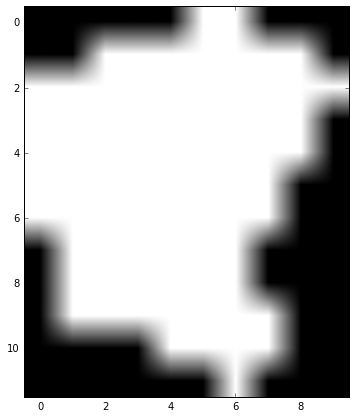

(width, height, channel): (12, 10)
After resizing to quadratic shape:  (12, 12)


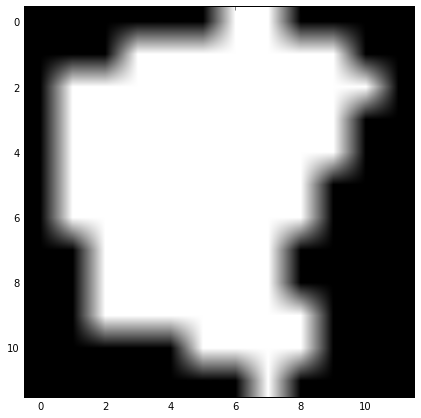

(width, height, channel): (12, 12)
Resize to MNIST (28x28) shape:  (28, 28)


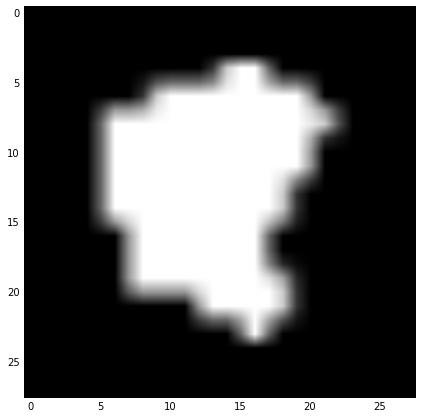

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


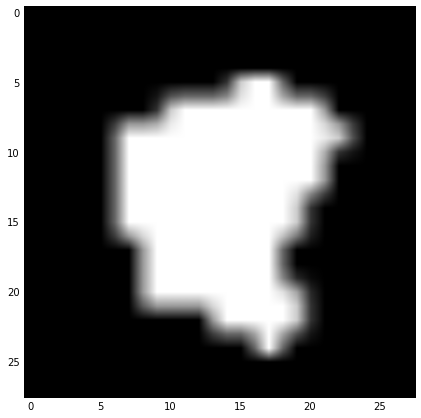

(width, height, channel): (28, 28)
pro-img/cropped_diget_250_500.png


Before resizing to quadratic shape:  (147, 95)


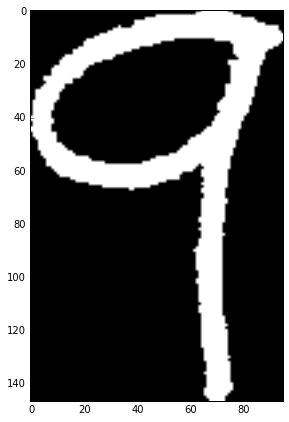

(width, height, channel): (147, 95)
After resizing to quadratic shape:  (147, 147)


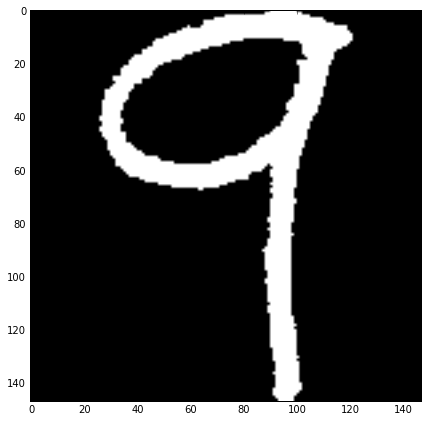

(width, height, channel): (147, 147)
Resize to MNIST (28x28) shape:  (28, 28)


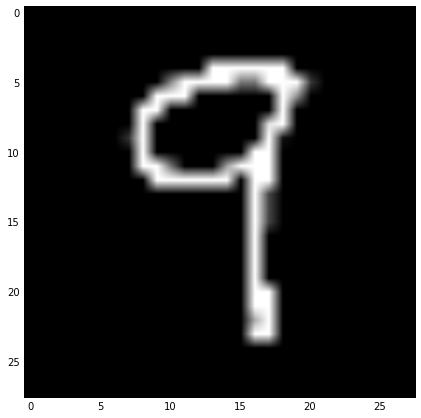

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


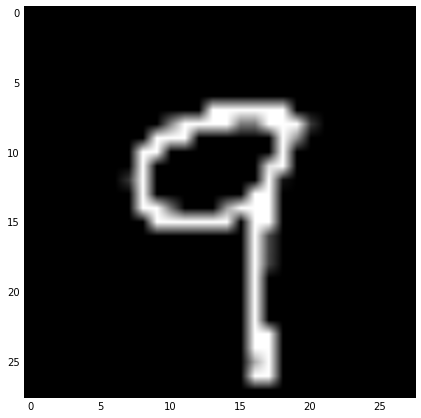

(width, height, channel): (28, 28)
pro-img/cropped_diget_1375_960.png


Before resizing to quadratic shape:  (137, 16)


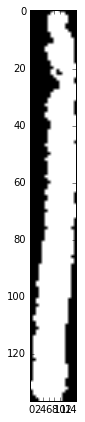

(width, height, channel): (137, 16)
After resizing to quadratic shape:  (137, 137)


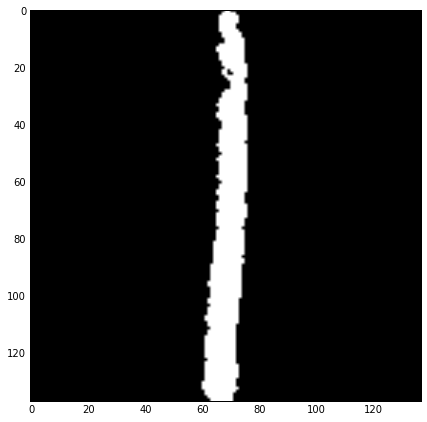

(width, height, channel): (137, 137)
Resize to MNIST (28x28) shape:  (28, 28)


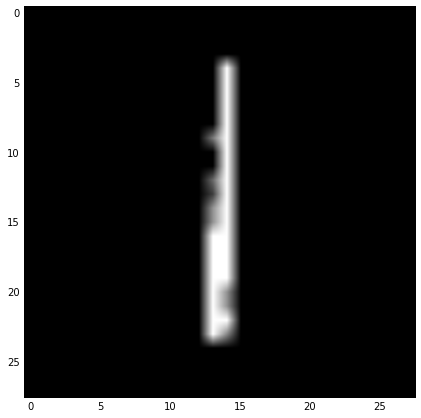

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


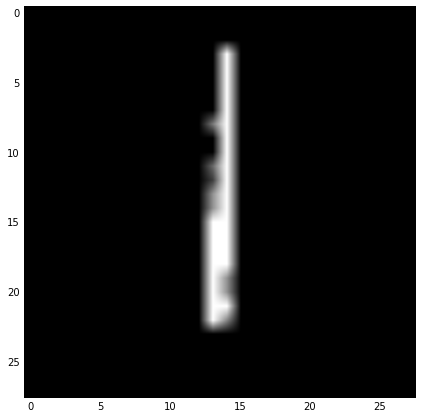

(width, height, channel): (28, 28)
pro-img/cropped_diget_275_1300.png


Before resizing to quadratic shape:  (189, 38)


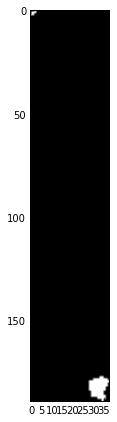

(width, height, channel): (189, 38)
After resizing to quadratic shape:  (189, 189)


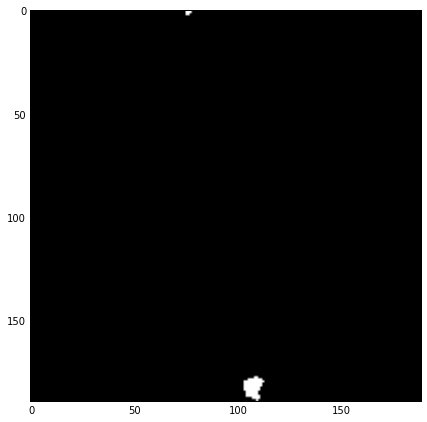

(width, height, channel): (189, 189)
Resize to MNIST (28x28) shape:  (28, 28)


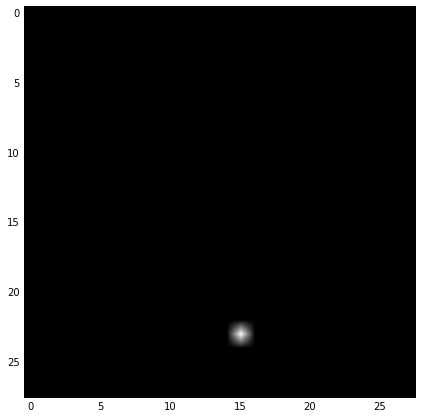

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


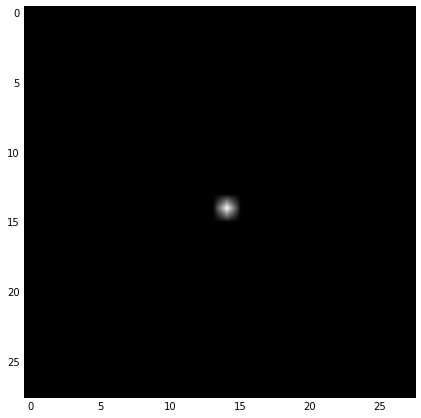

(width, height, channel): (28, 28)
pro-img/cropped_diget_250_385.png


Before resizing to quadratic shape:  (175, 128)


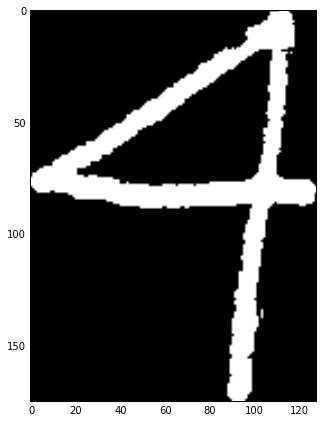

(width, height, channel): (175, 128)
After resizing to quadratic shape:  (175, 175)


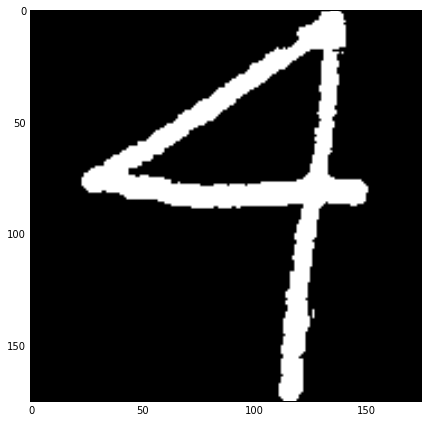

(width, height, channel): (175, 175)
Resize to MNIST (28x28) shape:  (28, 28)


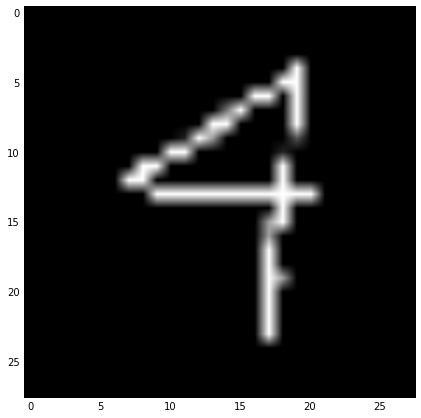

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


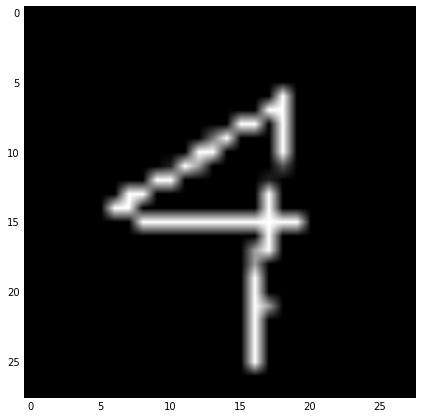

(width, height, channel): (28, 28)
pro-img/cropped_diget_700_950.png


Before resizing to quadratic shape:  (132, 130)


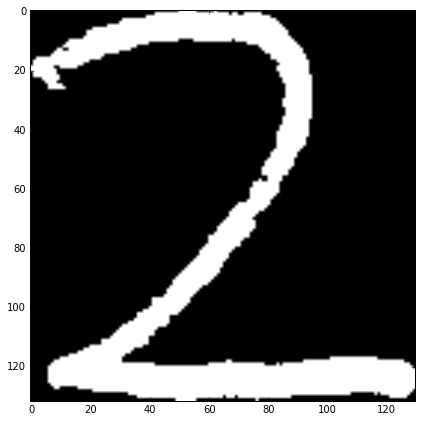

(width, height, channel): (132, 130)
After resizing to quadratic shape:  (132, 132)


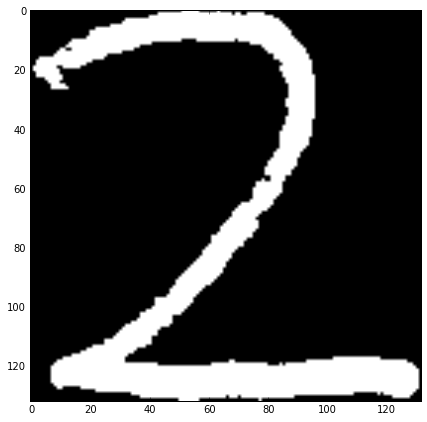

(width, height, channel): (132, 132)
Resize to MNIST (28x28) shape:  (28, 28)


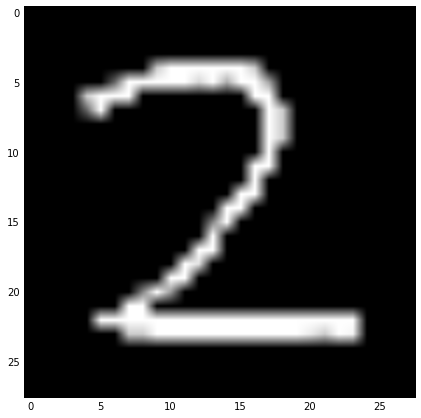

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


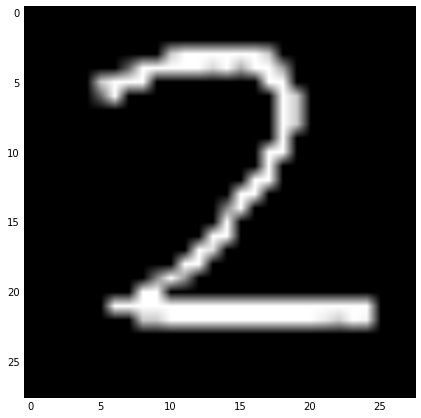

(width, height, channel): (28, 28)
pro-img/cropped_diget_720_1320.png


Before resizing to quadratic shape:  (171, 120)


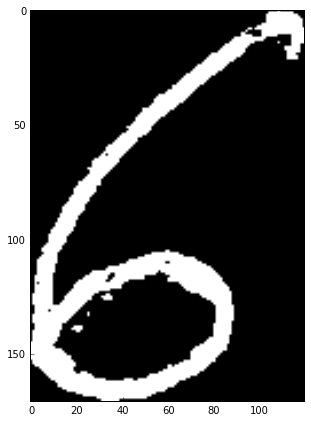

(width, height, channel): (171, 120)
After resizing to quadratic shape:  (171, 171)


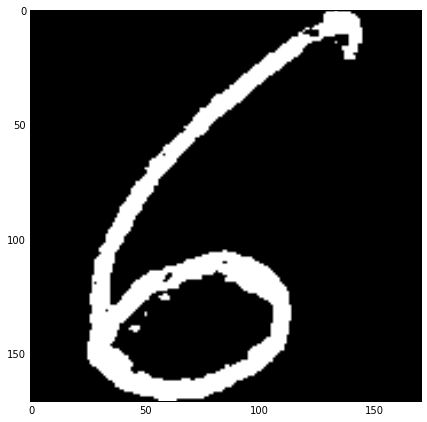

(width, height, channel): (171, 171)
Resize to MNIST (28x28) shape:  (28, 28)


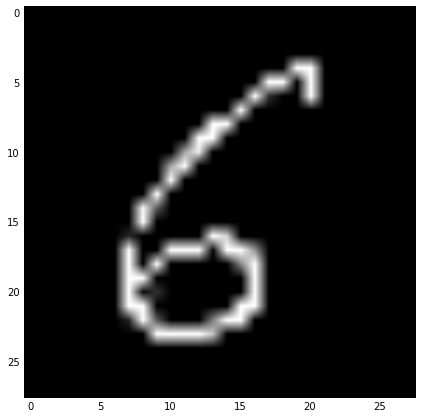

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


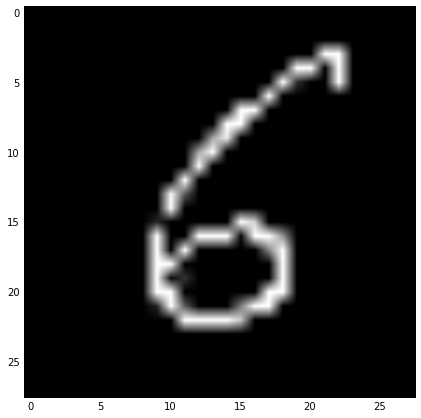

(width, height, channel): (28, 28)
pro-img/cropped_diget_1320_1650.png


Before resizing to quadratic shape:  (184, 131)


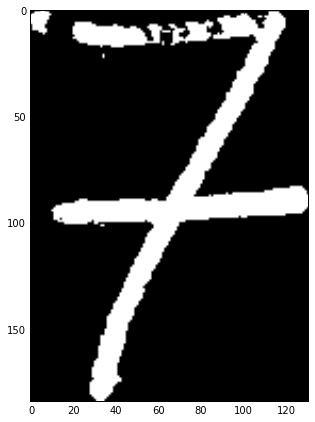

(width, height, channel): (184, 131)
After resizing to quadratic shape:  (184, 184)


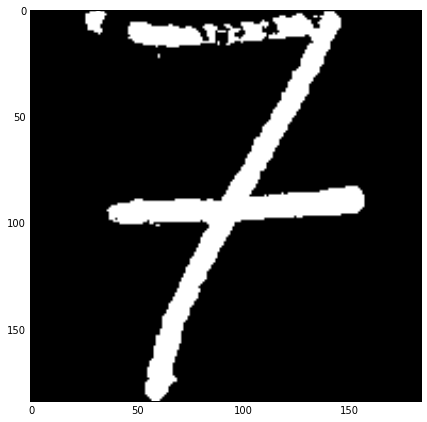

(width, height, channel): (184, 184)
Resize to MNIST (28x28) shape:  (28, 28)


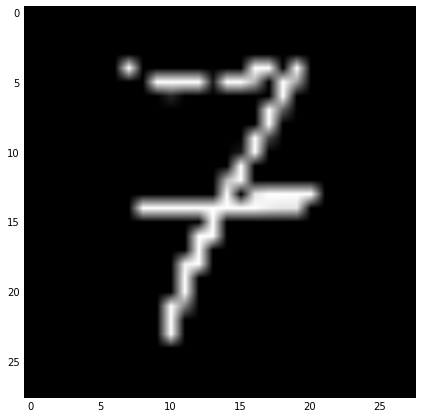

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


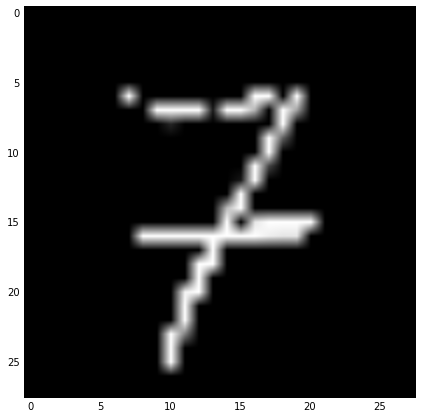

(width, height, channel): (28, 28)
pro-img/cropped_diget_320_550.png


Before resizing to quadratic shape:  (157, 139)


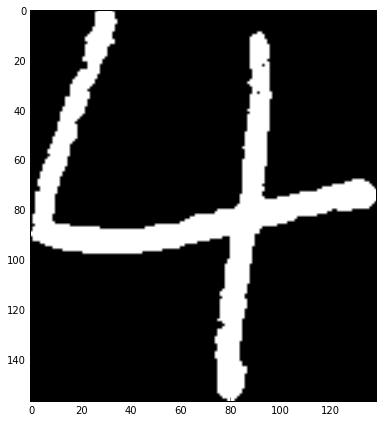

(width, height, channel): (157, 139)
After resizing to quadratic shape:  (157, 157)


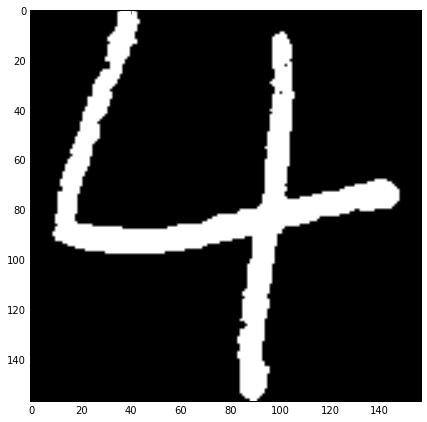

(width, height, channel): (157, 157)
Resize to MNIST (28x28) shape:  (28, 28)


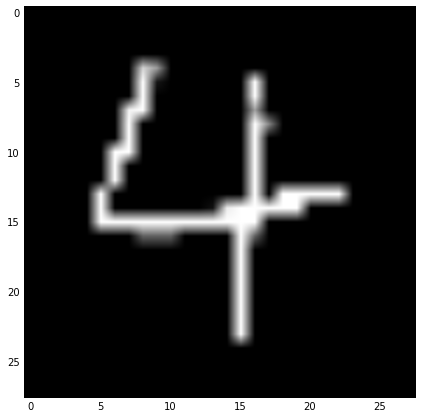

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


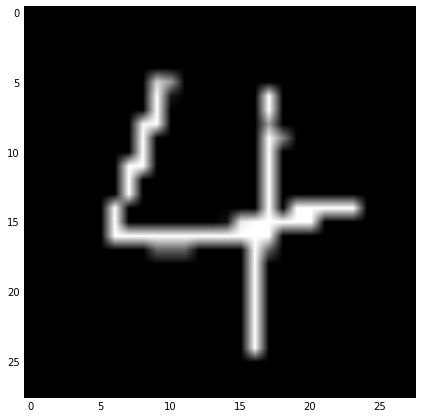

(width, height, channel): (28, 28)
pro-img/cropped_diget_270_945.png


Before resizing to quadratic shape:  (145, 131)


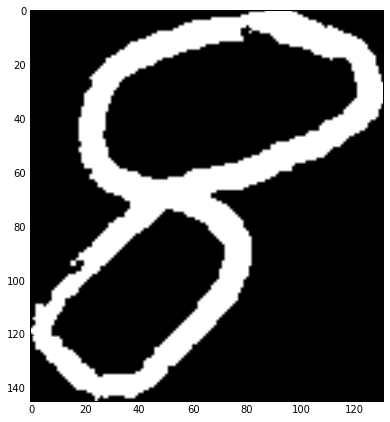

(width, height, channel): (145, 131)
After resizing to quadratic shape:  (145, 145)


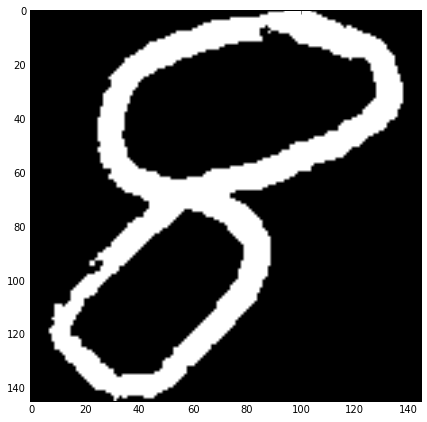

(width, height, channel): (145, 145)
Resize to MNIST (28x28) shape:  (28, 28)


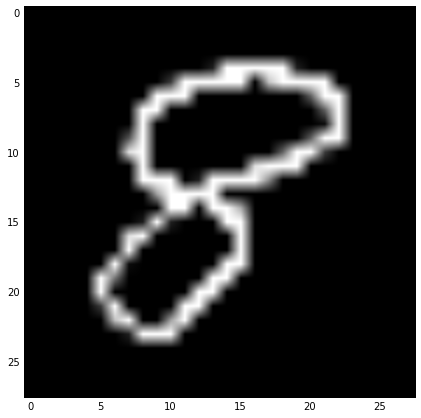

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


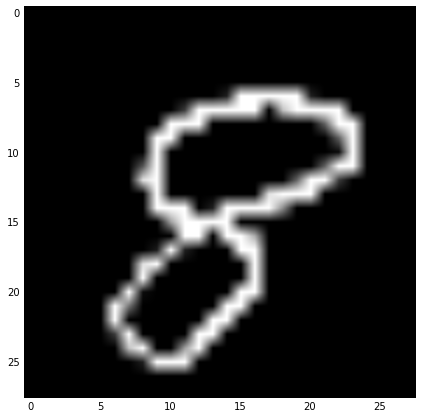

(width, height, channel): (28, 28)
pro-img/cropped_diget_720_585.png


Before resizing to quadratic shape:  (174, 132)


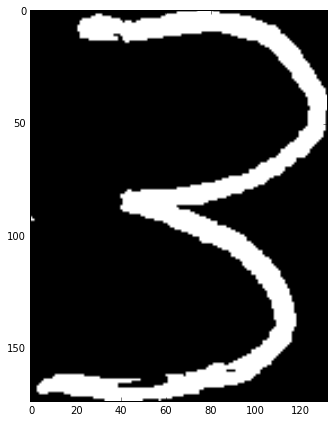

(width, height, channel): (174, 132)
After resizing to quadratic shape:  (174, 174)


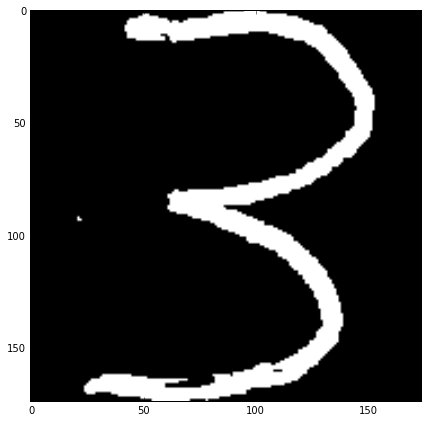

(width, height, channel): (174, 174)
Resize to MNIST (28x28) shape:  (28, 28)


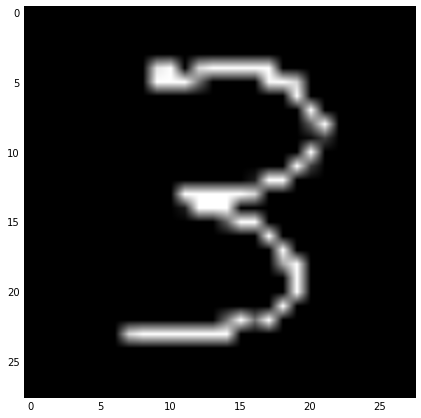

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


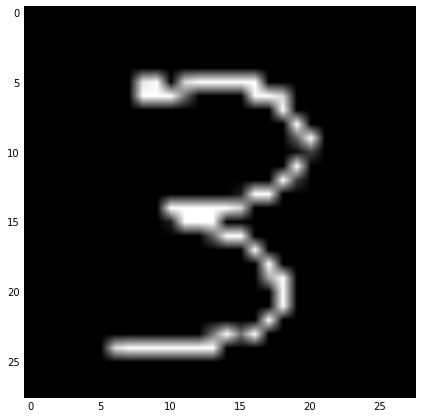

(width, height, channel): (28, 28)
pro-img/cropped_diget_1305_1265.png


Before resizing to quadratic shape:  (125, 159)


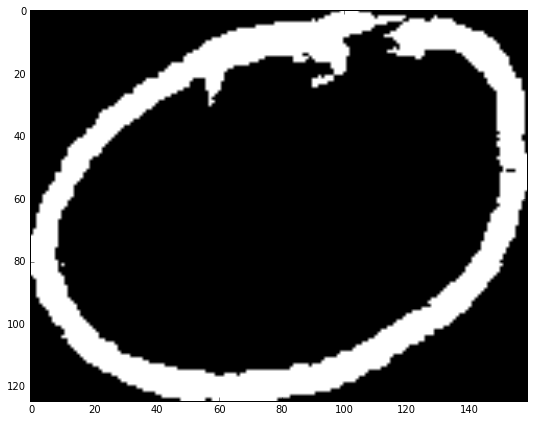

(width, height, channel): (125, 159)
After resizing to quadratic shape:  (159, 159)


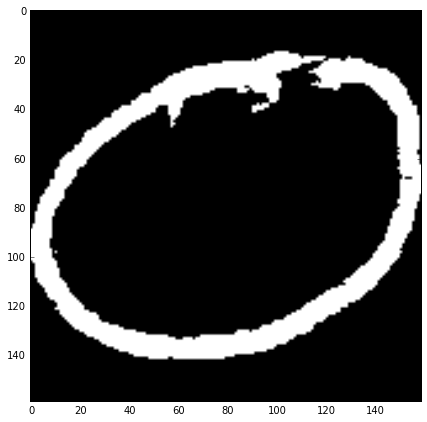

(width, height, channel): (159, 159)
Resize to MNIST (28x28) shape:  (28, 28)


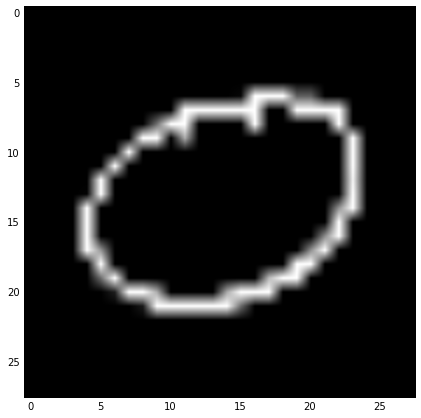

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


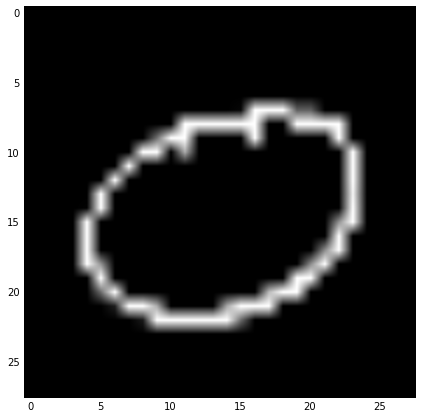

(width, height, channel): (28, 28)
pro-img/cropped_diget_1400_600.png


Before resizing to quadratic shape:  (165, 180)


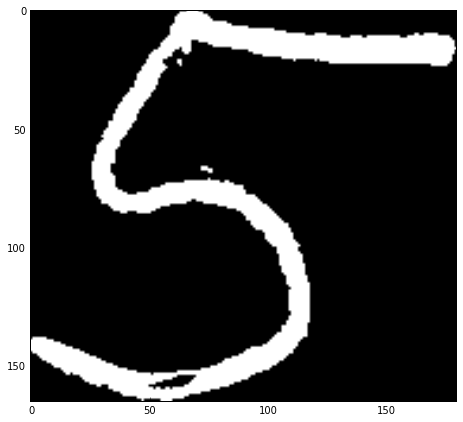

(width, height, channel): (165, 180)
After resizing to quadratic shape:  (180, 180)


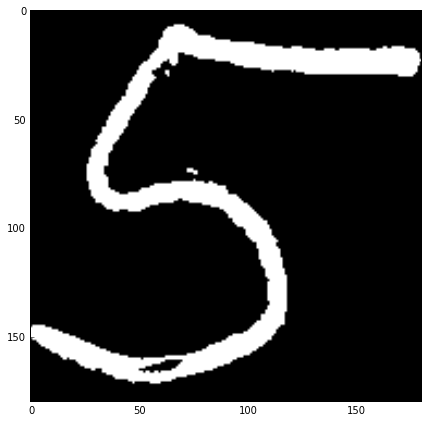

(width, height, channel): (180, 180)
Resize to MNIST (28x28) shape:  (28, 28)


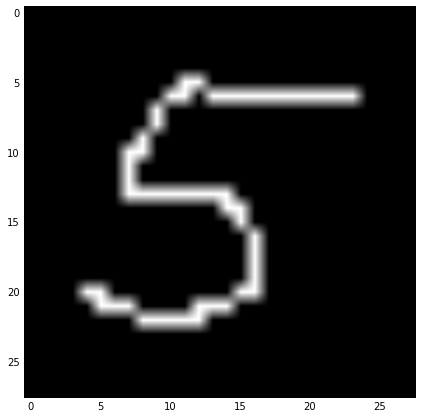

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


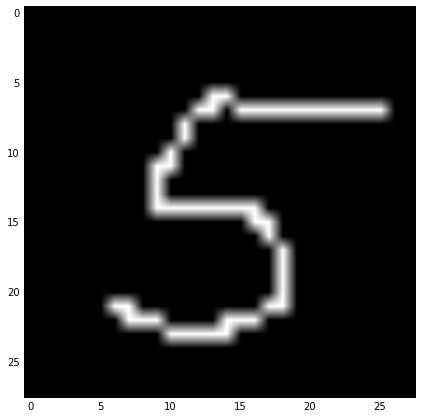

(width, height, channel): (28, 28)
pro-img/cropped_diget_250_1755.png


Before resizing to quadratic shape:  (219, 178)


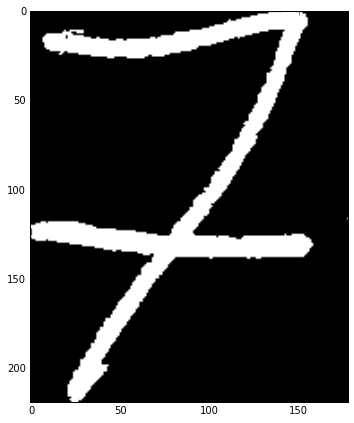

(width, height, channel): (219, 178)
After resizing to quadratic shape:  (219, 219)


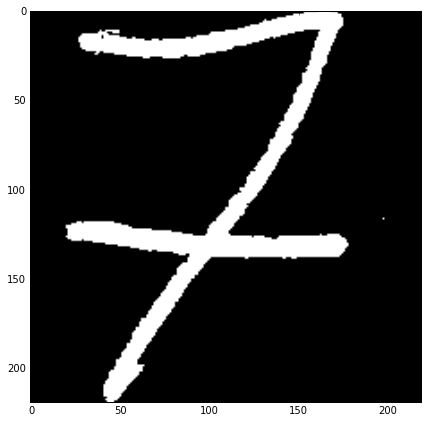

(width, height, channel): (219, 219)
Resize to MNIST (28x28) shape:  (28, 28)


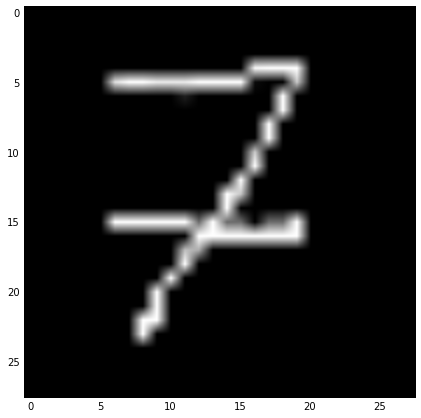

(width, height, channel): (28, 28)
Shift digit to be in the center of 28x28 box: 


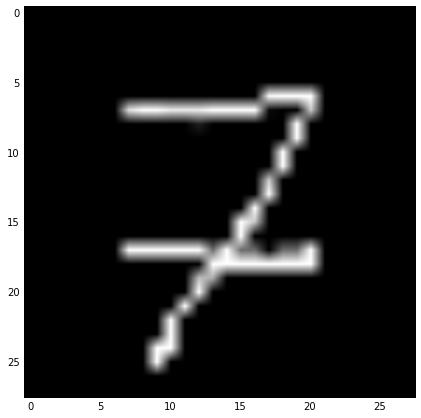

(width, height, channel): (28, 28)
pro-img/cropped_diget_715_2145.png




In [23]:
cropped_image_fileNames=[]
all_green_rectangle_positions=[]

# rectangle width (we have 100,120,140,...280)
for cropped_width in range(100, 300, 20):
    # rectangle height ( we habe 100,120,140 ... 280) 
    for cropped_height in range(100, 300, 20):
        # shift rectangle from left to right until full width of the image is reached (1836 pixel)
        for shift_x in range(0, width-cropped_width, cropped_width/4):
            # shift rectangle from top to bottom until full height of the image is reached (3264 pixel)
            for shift_y in range(0, height-cropped_height, cropped_height/4):
                # select a rectangle area out of the entire image ( crop the image )
                gray_cropped = inverse_image_data[shift_y:shift_y+cropped_height,shift_x:shift_x + cropped_width]
                
                # most likely its not a complete digit in the selected area, therefore break the loop.
                # there are less than 40 white digit pixels and the others are all black background pixels
                if np.count_nonzero(gray_cropped) <= 20:
                     continue
                        
                # If there is no white border, which means the digit is cut through somewhere, break the loop
                if (np.sum(gray_cropped[0]) != 0) or (np.sum(gray_cropped[:,0]) != 0) or (np.sum(gray_cropped[-1]) != 0) or (np.sum(gray_cropped[:,-1]) != 0):
                    continue
                                
                # Safe the position of the rectangle, which contains the digit.
                # The shape of this rectangle can be by far to big and could hold many surrounding black background pixels
                top_left = np.array([shift_y, shift_x])
                bottom_right = np.array([shift_y+cropped_height, shift_x + cropped_width])
                # reduce the rectangle shape to the minimum to contain almost only the digit ( tailoring )
                gray_tailored, top_left ,bottom_right = get_tailored_rectangle_position(top_left,bottom_right,gray_cropped)
   
                # check if on the same area coverd by the tailored rectangle, there was a digit found before
                if (check_if_digit_was_already_found(bottom_right,top_left,digit_image_found_marker)):
                    continue
                
                # resize the shape of the tailored image to be quadratic 
                gray_quadratic = resize_to_quadratic_image_shape(gray_tailored)

                
                # resize the image shape to meet MNIST requirements 28x28
                gray_MNIST_FORMAT = resize_to_MNIST_shape(gray_quadratic)

                # adjust digit in the center of the 28x28 box
                gray_shifted = center_digit_in_MNIST_frame(gray_MNIST_FORMAT)
                
                #safe pre-processed images to disk
                save_filename = dictionary_processing_files +"cropped_diget_"+str(shift_x)+"_"+str(shift_y)+".png"
                cv2.imwrite(save_filename, gray_shifted)
                cropped_image_fileNames.append(save_filename)
                print save_filename

                # Mark the image area where the digit was found as "searched and found (1)"
                digit_image_found_marker[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]] = 1
                
                print "\n ======================================================================================= \n"

                # single green rectangle positions to draw later with the predicted digit in image
                single_green_rectangle_shape = { 
                                           "filename": save_filename, 
                                           "top_left_0": top_left[0],  "top_left_1": top_left[1],
                                           "bottom_right_0": bottom_right[0],  "bottom_right_1": bottom_right[1]
                                          }
                all_green_rectangle_positions.append(single_green_rectangle_shape)

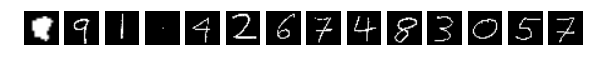

In [24]:
plotParallelFigures(cropped_image_fileNames,cmap="gray")
#girdPlot(cropped_image_fileNames,cmap="gray")

##### Safe results on disk

In [25]:
# position of the green rectangles              
with open(dictionary_processing_files + green_rectangle_positions, 'w') as outfile:
      json.dump(all_green_rectangle_positions, outfile)
print "file saved"

file saved


In [26]:
# copy of the original image where the green rectangles will be draw
im = Image.fromarray(image_data)
im.save(dictionary_processing_files + copy_image_file)
print "file saved"

file saved
